## Reading Single Cell profiles into the memory
- All the information about single cells are stored in a sqlite file for each plate
- sqlite files are huge (up to 50 GB) and loading them to memory may cause memory errors


#### Here are alternative ways of handling this issue:

- Reading All the Single Cells of a plate

- Reading random images or defind subset of the plate images 

- Reading a subset of wells from the plate 

- Reading a subset of features from the plate 

- Reading a subset of features and a subset of wells of a plate 
   
- Reading a subset of objects from a subset of wells plate    
  
  
** Timing Example **
* SQ00015195  :  11.55 GB

- Reading All the Single Cells of a plate

- Reading random images or defind subset of the plate images 

- Reading a subset of wells from the plate 

- Reading a subset of features from the plate 
   - One feature: 7 mins

- Reading a subset of features and a subset of wells of a plate 
   - One feature and one well: 0.6 mins
   
- Reading a subset of objects from a subset of wells plate    
  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import pandas as pd 
import time
import sys, os
# from utils import read_data, visualize_data
from utils.read_data import *
from utils.visualize_data import *
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
from functools import reduce
import time
from scipy.stats import pearsonr

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.2

In [4]:
# Example dataset:
#     drug rep
meta_lincs=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/results/synth_meta/meta_lincs_repLevel.csv")
rootDirDrug='/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace'
batchName='2016_04_01_a549_48hr_batch1'
p,wells="SQ00015195",["A13"]
fileName=rootDirDrug+"/backend/"+batchName+"/"+p+"/"+p+".sqlite"


###### Check file size

In [3]:
sqlFileSizGB=os.stat(fileName).st_size/10e8
print(p,' : ',sqlFileSizGB)

SQ00015195  :  11.553037312


## Reading All the Single Cells of a plate

## Reading random images or defind subset of the plate images 

In [ ]:
df_p_s=readSingleCellData_sqlalch_random_image_subset(fileName,50);

## Reading a subset of wells from the plate

In [ ]:
df_p_s=readSingleCellData_sqlalch_well_subset(fileName,wells);

## Reading a subset of objects from a subset of wells plate

In [ ]:
df_p_s=readSingleCellData_sqlalch_wellAndObject_subset(fileName,wells,50);

## Reading a subset of features from the plate 

In [15]:
selected_features='Cells_Intensity_IntegratedIntensity_DNA'
df_p_s=readSingleCellData_sqlalch_features_subset(fileName,selected_features);


time elapsed: 7.294410037994385


## Reading a subset of features and a subset of wells of a plate 

In [6]:
selected_features='Cells_Intensity_IntegratedIntensity_DNA'
wells=["A13"]

p,wells="SQ00015199", ['P20']
fileName=rootDirDrug+"/backend/"+batchName+"/"+p+"/"+p+".sqlite"
df_p_s=readSingleCellData_sqlalch_FeatureAndWell_subset(fileName,selected_features,wells);

time elapsed: 5.4183234333992  mins


In [33]:
# df_p_s.columns.duplicated()

In [ ]:
    sql_file="sqlite:////"+fileName
    engine = create_engine(sql_file)
    conn = engine.connect()
    compartments=["cells", "cytoplasm", "nuclei"]
    # compartments=["Neurites","CellBodies","CellBodiesPlusNeurites","Nuclei","Cytoplasm"]

#     rand_img_num=np.random.choice(range(1,4000), n_rand_ims)
#     rand_img_num=np.array(range(50))
#     list_str="("
#     for i in rand_img_num:
#         list_str=list_str+str(i)+',' 
#     list_str=list_str[:-1]+")"
    
#     rand_img_num=wells[:40]
    rand_img_num=wells.copy()
    list_str="('"
    for i in rand_img_num:
        list_str=list_str+str(i)+"','" 
    list_str=list_str[:-2]+")"

#     compartment_query = "select * from {}".format("Image")
#     compartment_query = "select * from {} WHERE {} IN {};".format("Image","ImageNumber",list_str)
#     compartment_query = "select * from {} WHERE {} IN {};".\
    compartment_query = "select * from {} WHERE {} IN {};".\
    format("Image","Image_Metadata_Well",list_str)
    start1 = time.time()
    plateImageDf= pd.read_sql(sql=compartment_query, con=conn);
#     print(plateImageDf.columns[plateImageDf.columns.str.contains("Metadata_")])
#     print(plateImageDf['Metadata_Well'].unique())
    end1 = time.time()
    print('time elapsed:',(end1 - start1)/60)
    img_nums=plateImageDf.ImageNumber.unique().tolist()
    print(plateImageDf.shape,img_nums)
    list_str2="("
    for i in img_nums:
        list_str2=list_str2+str(i)+',' 
    list_str2=list_str2[:-1]+")"
    start2 = time.time()
    plateDf_list=[]
    for compartment in compartments:
#         compartment_query = "select * from {}".format(compartment)
        compartment_query = "select * from {} WHERE {} IN {};".format(compartment,"ImageNumber",list_str2)
#         compartment_query = "select * from {} WHERE {} IN {};".format(compartment,"Metadata_Well",list_str)
        plateDf_list.append(pd.read_sql(sql=compartment_query, con=conn))

    plateDf = reduce(lambda left,right: pd.merge(left,right,on=["TableNumber", "ImageNumber", "ObjectNumber"]), plateDf_list)
    end = time.time()
    print('time elapsed:',(end - start2)/60)
    
#     print(plateDf.columns[plateDf.columns.str.contains("Metadata_")])
    plateDfwMeta = pd.merge(plateDf, plateImageDf, on=["TableNumber", "ImageNumber"])
    
    del plateDf
#     gc.collect()
    
    plateDfwMeta = plateDfwMeta.loc[:,~plateDfwMeta.columns.duplicated()]
#     print(plateDfwMeta.shape)
#     print(plateDfwMeta.Image_Metadata_ImageSizeX.values[0])
    plateDfwMeta=edgeCellFilter2(plateDfwMeta);  


In [13]:
meta_lincs_repLevel=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/\
workspace/results/synth_meta/meta_lincs_repLevel.csv")

rootDirDrug='/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace'
batchName='2016_04_01_a549_48hr_batch1'


selected_feature='Cells_Intensity_IntegratedIntensity_DNA'

pert_df=meta_lincs_repLevel[meta_lincs_repLevel['Metadata_pert_id_dose']=='BRD-K61567297_3.33'].reset_index(drop=True)
pert_df_allP0=[]
for j in range(pert_df.shape[0]):
    # p,wells="SQ00015195",["A13"]
    p,wells=pert_df.loc[j,"Metadata_Plate"],[pert_df.loc[j,"Metadata_Well"]]
    fileName=rootDirDrug+"/backend/"+batchName+"/"+p+"/"+p+".sqlite"

    print(p,wells)
    print("readSingleCellData_sqlalch_FeatureAndWell_subset")
    df_p_s=readSingleCellData_sqlalch_FeatureAndWell_subset(fileName,selected_feature,wells);
#     print("readSingleCellData_sqlalch_random_image_subset")
#     df_p_s=readSingleCellData_sqlalch_random_image_subset(fileName,50);
    print("readSingleCellData_sqlalch_well_subset")
    df_p_s=readSingleCellData_sqlalch_well_subset(fileName,wells);
#     print("readSingleCellData_sqlalch_wellAndObject_subset")
#     df_p_s=readSingleCellData_sqlalch_wellAndObject_subset(fileName,wells,50);

    pert_df_allP0.append(df_p_s)

pert_df_allP = pd.concat(pert_df_allP0)


# readSingleCellData_sqlalch_well_subset(fileName,wells):

SQ00015199 ['P20']
readSingleCellData_sqlalch_FeatureAndWell_subset
time elapsed: 5.229200692971547  mins
readSingleCellData_sqlalch_well_subset
time elapsed: 4.095426261425018
(9, 658) [3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420]
time elapsed: 2.020168689886729
SQ00015134 ['P20']
readSingleCellData_sqlalch_FeatureAndWell_subset


KeyboardInterrupt: 

In [3]:
# selected_feature='Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16'
#     selected_feature='Cells_Intensity_IntegratedIntensity_DNA'
# f2='Cells_Intensity_IntegratedIntensity_DNA'

sql_file="sqlite:////"+fileName
engine = create_engine(sql_file)
conn = engine.connect()

######## Query wells from Image table
ls_wells=wells.copy()
list_str="('"
for i in ls_wells:
    list_str=list_str+str(i)+"','" 
list_str=list_str[:-2]+")"

img_query = "select * from {} WHERE {} IN {};".\
format("Image","Image_Metadata_Well",list_str)

plateImageDf= pd.read_sql(sql=img_query, con=conn);
img_nums=plateImageDf.ImageNumber.unique().tolist()

list_str2="("
for i in img_nums:
    list_str2=list_str2+str(i)+',' 
list_str2=list_str2[:-1]+")"
###########################

In [7]:
selected_features='Cells_Intensity_IntegratedIntensity_DNA'
start1 = time.time()
compartments=selected_features.split("_")[0]
query_cols = "TableNumber, ImageNumber, "+selected_features#+", "+f2
compartment_query = "select {} from {} WHERE {} IN {};".format(query_cols,compartments,"ImageNumber",list_str2)
plateDf=pd.read_sql(sql=compartment_query, con=conn)

plateDfwMeta = pd.merge(plateDf, plateImageDf, on=["TableNumber", "ImageNumber"])

end1 = time.time()
print('time elapsed:',(end1 - start1)/60, " mins")

time elapsed: 0.07481953700383505  mins


In [27]:
meta_lincs.columns

Index(['alternative_moa', 'Metadata_Batch_Number', 'Metadata_pert_id_vendor',
       'Batch_Number', 'InChIKey14', 'moa', 'Metadata_pert_vehicle',
       'Metadata_broad_id', 'Metadata_mg_per_ml', 'broad_date', 'broad_id',
       'Metadata_cell_id', 'Metadata_alternative_moa',
       'Metadata_Assay_Plate_Barcode', 'Metadata_pert_well', 'plate_map_name',
       'Metadata_target', 'Metadata_Plate', 'Metadata_pert_type',
       'Metadata_mmoles_per_liter', 'Metadata_broad_sample_type', 'Batch_Date',
       'pert_iname', 'Metadata_moa', 'Metadata_alternative_target',
       'Metadata_broad_sample', 'Metadata_dose_recode', 'Metadata_Well',
       'Metadata_InChIKey14', 'clinical_phase', 'target', 'Metadata_pert_id',
       'Metadata_Batch_Date', 'Metadata_pert_id_dose', 'solvent',
       'alternative_target', 'Metadata_pert_mfc_id', 'Metadata_plate_map_name',
       'Metadata_Plate_Map_Name', 'Metadata_broad_date', 'Metadata_solvent'],
      dtype='object')

In [45]:
meta_lincs.groupby(["Metadata_broad_sample","Metadata_mmoles_per_liter"]).size()

Metadata_broad_sample   Metadata_mmoles_per_liter
BRD-A00147595-001-01-5  0.04                            4
                        0.12                            4
                        0.37                            4
                        1.11                            4
                        3.33                            4
                                                     ... 
BRD-M98279124-300-01-1  0.37                            5
                        1.11                            5
                        3.33                            5
                        10.00                           5
DMSO                    0.00                         3264
Length: 9411, dtype: int64

In [28]:
drug_list_rank

,Unnamed: 0,Metadata_broad_sample,Metadata_mmoles_per_liter,0,Metadata_moa,Metadata_pert_name,Count_Cells,phenotype_abundance_pval,phenotype_abundance_t
0,3802,BRD-K24576554-001-04-8,0.37,5,Aurora kinase inhibitor|JAK inhibitor,AT-9283,499,5.144916e-07,57.690956
1,1290,BRD-A61221616-001-04-3,0.04,5,progesterone receptor agonist,medroxyprogesterone-acetate,2006,3.914460e-06,30.592161
2,3801,BRD-K24576554-001-04-8,0.12,5,Aurora kinase inhibitor|JAK inhibitor,AT-9283,586,6.954569e-06,30.293511
3,2626,BRD-K07881437-001-03-8,0.37,5,Aurora kinase inhibitor|growth factor receptor...,danusertib,353,1.088438e-05,27.103758
4,3630,BRD-K21718444-001-06-8,3.33,5,Abl kinase inhibitor|Aurora kinase inhibitor|F...,KW-2449,578,1.205541e-05,26.441848
...,...,...,...,...,...,...,...,...,...
9390,9371,BRD-M39350793-334-01-1,0.12,1,adrenergic receptor antagonist,reboxetine,2410,NaN,NaN
9391,9372,BRD-M39350793-334-01-1,0.37,1,adrenergic receptor antagonist,reboxetine,2359,NaN,NaN
9392,9373,BRD-M39350793-334-01-1,1.11,1,adrenergic receptor antagonist,reboxetine,2856,NaN,NaN
9393,9374,BRD-M39350793-334-01-1,3.33,1,adrenergic receptor antagonist,reboxetine,2654,NaN,NaN


In [42]:
# pd.merge(drug_list_rank,meta_lincs,on=["Metadata_broad_sample"],how="inner")
X_Metadata_broad_sample,X_Metadata_mmoles_per_liter="BRD-K24576554-001-04-8", 0.37
meta_lincs[(meta_lincs["Metadata_broad_sample"]==X_Metadata_broad_sample) &\
           (meta_lincs["Metadata_mmoles_per_liter"]==X_Metadata_mmoles_per_liter)]

,alternative_moa,Metadata_Batch_Number,Metadata_pert_id_vendor,Batch_Number,InChIKey14,moa,Metadata_pert_vehicle,Metadata_broad_id,Metadata_mg_per_ml,broad_date,...,Metadata_pert_id,Metadata_Batch_Date,Metadata_pert_id_dose,solvent,alternative_target,Metadata_pert_mfc_id,Metadata_plate_map_name,Metadata_Plate_Map_Name,Metadata_broad_date,Metadata_solvent
31100,NaN,1,NaN,1.0,LOLPPWBBNUVNQZ,Aurora kinase inhibitor|JAK inhibitor,DMSO,BRD-K24576554,0.14127,broad_id_20170327,...,BRD-K24576554,2016-03-22,BRD-K24576554_0.37,DMSO,NaN,BRD-K24576554-001-04-8,C-7161-01-LM6-006,C-7161-01-LM6-006,broad_id_20170327,DMSO
31484,NaN,2,NaN,2.0,LOLPPWBBNUVNQZ,Aurora kinase inhibitor|JAK inhibitor,DMSO,BRD-K24576554,0.14127,broad_id_20170327,...,BRD-K24576554,2016-04-05,BRD-K24576554_0.37,DMSO,NaN,BRD-K24576554-001-04-8,C-7161-01-LM6-006,C-7161-01-LM6-006,broad_id_20170327,DMSO
31868,NaN,2,NaN,2.0,LOLPPWBBNUVNQZ,Aurora kinase inhibitor|JAK inhibitor,DMSO,BRD-K24576554,0.14127,broad_id_20170327,...,BRD-K24576554,2016-04-05,BRD-K24576554_0.37,DMSO,NaN,BRD-K24576554-001-04-8,C-7161-01-LM6-006,C-7161-01-LM6-006,broad_id_20170327,DMSO
32252,NaN,2,NaN,2.0,LOLPPWBBNUVNQZ,Aurora kinase inhibitor|JAK inhibitor,DMSO,BRD-K24576554,0.14127,broad_id_20170327,...,BRD-K24576554,2016-04-05,BRD-K24576554_0.37,DMSO,NaN,BRD-K24576554-001-04-8,C-7161-01-LM6-006,C-7161-01-LM6-006,broad_id_20170327,DMSO
32636,NaN,2,NaN,2.0,LOLPPWBBNUVNQZ,Aurora kinase inhibitor|JAK inhibitor,DMSO,BRD-K24576554,0.14127,broad_id_20170327,...,BRD-K24576554,2016-04-05,BRD-K24576554_0.37,DMSO,NaN,BRD-K24576554-001-04-8,C-7161-01-LM6-006,C-7161-01-LM6-006,broad_id_20170327,DMSO


In [43]:
meta_lincs.columns

Index(['alternative_moa', 'Metadata_Batch_Number', 'Metadata_pert_id_vendor',
       'Batch_Number', 'InChIKey14', 'moa', 'Metadata_pert_vehicle',
       'Metadata_broad_id', 'Metadata_mg_per_ml', 'broad_date', 'broad_id',
       'Metadata_cell_id', 'Metadata_alternative_moa',
       'Metadata_Assay_Plate_Barcode', 'Metadata_pert_well', 'plate_map_name',
       'Metadata_target', 'Metadata_Plate', 'Metadata_pert_type',
       'Metadata_mmoles_per_liter', 'Metadata_broad_sample_type', 'Batch_Date',
       'pert_iname', 'Metadata_moa', 'Metadata_alternative_target',
       'Metadata_broad_sample', 'Metadata_dose_recode', 'Metadata_Well',
       'Metadata_InChIKey14', 'clinical_phase', 'target', 'Metadata_pert_id',
       'Metadata_Batch_Date', 'Metadata_pert_id_dose', 'solvent',
       'alternative_target', 'Metadata_pert_mfc_id', 'Metadata_plate_map_name',
       'Metadata_Plate_Map_Name', 'Metadata_broad_date', 'Metadata_solvent'],
      dtype='object')

,Metadata_broad_sample,Metadata_mmoles_per_liter,Metadata_Plate,Metadata_Well,0
0,BRD-A00147595-001-01-5,0.04,SQ00015196,B12,1
1,BRD-A00147595-001-01-5,0.04,SQ00015222,B12,1
2,BRD-A00147595-001-01-5,0.04,SQ00015223,B12,1
3,BRD-A00147595-001-01-5,0.04,SQ00015224,B12,1
4,BRD-A00147595-001-01-5,0.12,SQ00015196,B11,1
...,...,...,...,...,...
52218,DMSO,0.00,SQ00015233,J14,1
52219,DMSO,0.00,SQ00015233,J15,1
52220,DMSO,0.00,SQ00015233,J16,1
52221,DMSO,0.00,SQ00015233,J17,1


In [54]:
# drug_list_rank.loc[0,['Metadata_broad_sample','Metadata_mmoles_per_liter']].values

In [56]:
X_Metadata_broad_sample,X_Metadata_mmoles_per_liter=drug_list_rank.loc[1,['Metadata_broad_sample','Metadata_mmoles_per_liter']].values

In [64]:
# X_Metadata_mmoles_per_liter
meta_lincs2

,Metadata_broad_sample,Metadata_mmoles_per_liter,Metadata_Plate,Metadata_Well,0
0,BRD-A00147595-001-01-5,0.04,SQ00015196,B12,1
1,BRD-A00147595-001-01-5,0.04,SQ00015222,B12,1
2,BRD-A00147595-001-01-5,0.04,SQ00015223,B12,1
3,BRD-A00147595-001-01-5,0.04,SQ00015224,B12,1
4,BRD-A00147595-001-01-5,0.12,SQ00015196,B11,1
...,...,...,...,...,...
52218,DMSO,0.00,SQ00015233,J14,1
52219,DMSO,0.00,SQ00015233,J15,1
52220,DMSO,0.00,SQ00015233,J16,1
52221,DMSO,0.00,SQ00015233,J17,1


In [66]:
meta_lincs2[(meta_lincs2["Metadata_broad_sample"]==X_Metadata_broad_sample) &\
           (meta_lincs2["Metadata_mmoles_per_liter"]==X_Metadata_mmoles_per_liter)]

,Metadata_broad_sample,Metadata_mmoles_per_liter,Metadata_Plate,Metadata_Well,0
18513,BRD-K24576554-001-04-8,0.37,SQ00015130,P22,1
18514,BRD-K24576554-001-04-8,0.37,SQ00015165,P22,1
18515,BRD-K24576554-001-04-8,0.37,SQ00015166,P22,1
18516,BRD-K24576554-001-04-8,0.37,SQ00015167,P22,1
18517,BRD-K24576554-001-04-8,0.37,SQ00015168,P22,1


# [Mito Project]
- For top 20 and bottom 20 compounds in the ranked list:
    - Read single cell of all replicates and save them in the .pkl file in the below location
    /home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/drugSCprofiles

In [51]:
import pickle
# from funcs.utils import readSingleCellData_sqlalch_well_subset,readSingleCellData_sqlalch_random_image_subset

drug_list_rank=pd.read_excel("/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/\
workspace/Metadata_drugRep/drugList_20210115_uncorrForSiteAgg.xlsx")
drug_list_rank=drug_list_rank[~drug_list_rank["phenotype_abundance_pval"].isnull()]
drug_list_rank_Top=drug_list_rank.loc[0:20].append(drug_list_rank.loc[drug_list_rank.shape[0]-20:]).reset_index(drop=True)
# drug_list_rank=drug_list_rank.sort_values(by=['phenotype_abundance_t'],ascending=1)

meta_lincs=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/\
workspace/results/synth_meta/meta_lincs_repLevel.csv")
meta_lincs.Metadata_mmoles_per_liter=meta_lincs.Metadata_mmoles_per_liter.values.round(2)
meta_lincs2=meta_lincs.groupby(['Metadata_broad_sample','Metadata_mmoles_per_liter','Metadata_Plate','Metadata_Well']).size().reset_index()


rootDirDrug='/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace'
batchName='2016_04_01_a549_48hr_batch1_Mito_Project'

# cp_features=mergProf_treatLevel_lincs.columns[mergProf_treatLevel_lincs.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()
              
# pert_plate_well=mergProf_treatLevel_lincs.groupby(['PERT','Metadata_Plate','Metadata_Well']).size().reset_index()
# PERTS=pert_plate_well.PERT.unique().tolist()



for row in range(drug_list_rank_Top.shape[0]):#[1140:]:
    X_Metadata_broad_sample,X_Metadata_mmoles_per_liter=\
    drug_list_rank_Top.loc[row,['Metadata_broad_sample','Metadata_mmoles_per_liter']].values;
    
    
    pert=X_Metadata_broad_sample+"_"+str(X_Metadata_mmoles_per_liter)
    print(pert)
    pert_df=meta_lincs2[(meta_lincs2["Metadata_broad_sample"]==X_Metadata_broad_sample) &\
           (meta_lincs2["Metadata_mmoles_per_liter"]==X_Metadata_mmoles_per_liter)].reset_index(drop=True)
    start_time = time.time()
    
    pert_df_allP0=[]
    pert_df_dmsos0=[]
    for j in range(pert_df.shape[0]):
        # p,wells="SQ00015195",["A13"]
        p,wells=pert_df.loc[j,"Metadata_Plate"],[pert_df.loc[j,"Metadata_Well"]]
        fileName=rootDirDrug+"/backend/"+batchName+"/"+p+"/"+p+".sqlite"
        
        print(p,wells)
        # df_p_s=readSingleCellData_sqlalch_random_image_subset(fileName,50);
        df_p_s=readSingleCellData_sqlalch_well_subset(fileName,wells);
        pert_df_allP0.append(df_p_s)
        
        ## fo DMSO
        wells=meta_lincs2[(meta_lincs2["Metadata_Plate"]==p) & (meta_lincs2["Metadata_broad_sample"]=="DMSO")].Metadata_Well.tolist()
        df_p_s0=readSingleCellData_sqlalch_well_subset(fileName,wells);
        pert_df_dmsos0.append(df_p_s0.sample(500))
    
    pert_df_allP = pd.concat(pert_df_allP0)
    pert_df_dmsos = pd.concat(pert_df_dmsos0)
    
    perWellData={}
    perWellData['cp_ss']=pert_df_allP
    perWellData['cp_ss_control']=pert_df_dmsos
    
    a_file = open("/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/drugSCprofiles/"+pert+".pkl", "wb")
    pickle.dump(perWellData, a_file)
    a_file.close()
#     perWellData.to_pickle('/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/synth_l1k_ssCP_meta/'+pert);
    print("--- %s minutes ---" % ((time.time() - start_time)/60))

BRD-K24576554-001-04-8_0.37
SQ00015130 ['P22']
SQ00015130 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015165 ['P22']
SQ00015165 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015166 ['P22']
SQ00015166 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015167 ['P22']
SQ00015167 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015168 ['P22']
SQ00015168 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15'

SQ00015134 ['L16']
SQ00015134 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015135 ['L16']
SQ00015135 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['L16']
SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015137 ['L16']
SQ00015137 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015199 ['L16']
SQ00015199 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
BRD-K

SQ00015120 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015121 ['J10']
SQ00015121 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['J10']
SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015123 ['J10']
SQ00015123 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015126 ['J10']
SQ00015126 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
BRD-K62965247-001-04-9_0

SQ00015215 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015216 ['D06']
SQ00015216 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015217 ['D06']
SQ00015217 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
BRD-K90195324-003-02-5_10.0
SQ00015048 ['H07']
SQ00015048 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015049 ['H07']
SQ00015049 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J1

SQ00014812 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014812 ['G16']
SQ00014812 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014812 ['G17']
SQ00014812 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014812 ['G18']
SQ00014812 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014813 ['C19']
SQ00014813 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014813 ['C20']
SQ000

SQ00014816 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014816 ['C24']
SQ00014816 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014816 ['G13']
SQ00014816 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014816 ['G14']
SQ00014816 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014816 ['G15']
SQ00014816 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014816 ['G16']
SQ000

SQ00014819 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014819 ['G18']
SQ00014819 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014820 ['C19']
SQ00014820 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014820 ['C20']
SQ00014820 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014820 ['C21']
SQ00014820 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014820 ['C22']
SQ000

SQ00015043 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015043 ['G16']
SQ00015043 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015043 ['G17']
SQ00015043 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015043 ['G18']
SQ00015043 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015044 ['C19']
SQ00015044 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015044 ['C20']
SQ000

SQ00015047 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015047 ['C22']
SQ00015047 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015047 ['C23']
SQ00015047 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015047 ['C24']
SQ00015047 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015047 ['G13']
SQ00015047 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015047 ['G14']
SQ000

SQ00015050 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015050 ['G16']
SQ00015050 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015050 ['G17']
SQ00015050 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015050 ['G18']
SQ00015050 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015051 ['C19']
SQ00015051 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015051 ['C20']
SQ000

SQ00015054 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015054 ['C22']
SQ00015054 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015054 ['C23']
SQ00015054 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015054 ['C24']
SQ00015054 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015054 ['G13']
SQ00015054 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015054 ['G14']
SQ000

SQ00015057 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015057 ['G16']
SQ00015057 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015057 ['G17']
SQ00015057 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015057 ['G18']
SQ00015057 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015058 ['C19']
SQ00015058 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015058 ['C20']
SQ000

SQ00015097 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015097 ['C22']
SQ00015097 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015097 ['C23']
SQ00015097 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015097 ['C24']
SQ00015097 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015097 ['G13']
SQ00015097 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015097 ['G14']
SQ000

SQ00015100 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015100 ['G17']
SQ00015100 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015100 ['G18']
SQ00015100 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015101 ['C19']
SQ00015101 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015101 ['C20']
SQ00015101 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015101 ['C21']
SQ000

SQ00015105 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015105 ['C23']
SQ00015105 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015105 ['C24']
SQ00015105 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015105 ['G13']
SQ00015105 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015105 ['G14']
SQ00015105 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015105 ['G15']
SQ000

SQ00015108 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015108 ['G17']
SQ00015108 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015108 ['G18']
SQ00015108 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015109 ['C19']
SQ00015109 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015109 ['C20']
SQ00015109 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015109 ['C21']
SQ000

SQ00015112 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015112 ['G13']
SQ00015112 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015112 ['G14']
SQ00015112 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015112 ['G15']
SQ00015112 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015112 ['G16']
SQ00015112 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015112 ['G17']
SQ000

SQ00015118 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015119 ['C19']
SQ00015119 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015119 ['C20']
SQ00015119 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015119 ['C21']
SQ00015119 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015119 ['C22']
SQ00015119 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015119 ['C23']
SQ000

SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['G14']
SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['G15']
SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['G16']
SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['G17']
SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['G18']
SQ000

SQ00015126 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015126 ['C20']
SQ00015126 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015126 ['C21']
SQ00015126 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015126 ['C22']
SQ00015126 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015126 ['C23']
SQ00015126 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015126 ['C24']
SQ000

SQ00015129 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015129 ['G14']
SQ00015129 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015129 ['G15']
SQ00015129 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015129 ['G16']
SQ00015129 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015129 ['G17']
SQ00015129 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015129 ['G18']
SQ000

SQ00015133 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015133 ['C20']
SQ00015133 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015133 ['C21']
SQ00015133 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015133 ['C22']
SQ00015133 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015133 ['C23']
SQ00015133 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015133 ['C24']
SQ000

SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['G14']
SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['G15']
SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['G16']
SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['G17']
SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['G18']
SQ000

SQ00015140 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015140 ['C20']
SQ00015140 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015140 ['C21']
SQ00015140 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015140 ['C22']
SQ00015140 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015140 ['C23']
SQ00015140 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015140 ['C24']
SQ000

SQ00015143 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015143 ['G14']
SQ00015143 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015143 ['G15']
SQ00015143 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015143 ['G16']
SQ00015143 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015143 ['G17']
SQ00015143 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015143 ['G18']
SQ000

SQ00015147 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015147 ['C20']
SQ00015147 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015147 ['C21']
SQ00015147 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015147 ['C22']
SQ00015147 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015147 ['C23']
SQ00015147 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015147 ['C24']
SQ000

SQ00015150 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015150 ['G14']
SQ00015150 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015150 ['G15']
SQ00015150 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015150 ['G16']
SQ00015150 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015150 ['G17']
SQ00015150 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015150 ['G18']
SQ000

SQ00015154 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015154 ['C20']
SQ00015154 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015154 ['C21']
SQ00015154 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015154 ['C22']
SQ00015154 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015154 ['C23']
SQ00015154 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015154 ['C24']
SQ000

SQ00015157 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015158 ['C19']
SQ00015158 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015158 ['C20']
SQ00015158 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015158 ['C21']
SQ00015158 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015158 ['C22']
SQ00015158 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015158 ['C23']
SQ000

SQ00015163 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015163 ['G16']
SQ00015163 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015163 ['G17']
SQ00015163 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015163 ['G18']
SQ00015163 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015164 ['C19']
SQ00015164 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015164 ['C20']
SQ000

SQ00015168 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015168 ['C21']
SQ00015168 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015168 ['C22']
SQ00015168 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015168 ['C23']
SQ00015168 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015168 ['C24']
SQ00015168 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015168 ['G13']
SQ000

SQ00015171 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015171 ['G15']
SQ00015171 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015171 ['G16']
SQ00015171 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015171 ['G17']
SQ00015171 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015171 ['G18']
SQ00015171 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015172 ['C19']
SQ000

SQ00015195 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015195 ['C21']
SQ00015195 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015195 ['C22']
SQ00015195 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015195 ['C23']
SQ00015195 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015195 ['C24']
SQ00015195 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015195 ['G13']
SQ000

SQ00015198 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015198 ['G15']
SQ00015198 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015198 ['G16']
SQ00015198 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015198 ['G17']
SQ00015198 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015198 ['G18']
SQ00015198 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015199 ['C19']
SQ000

SQ00015202 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015202 ['C21']
SQ00015202 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015202 ['C22']
SQ00015202 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015202 ['C23']
SQ00015202 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015202 ['C24']
SQ00015202 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015202 ['G13']
SQ000

SQ00015205 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015205 ['G15']
SQ00015205 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015205 ['G16']
SQ00015205 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015205 ['G17']
SQ00015205 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015205 ['G18']
SQ00015205 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015206 ['C19']
SQ000

SQ00015209 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015209 ['C21']
SQ00015209 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015209 ['C22']
SQ00015209 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015209 ['C23']
SQ00015209 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015209 ['C24']
SQ00015209 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015209 ['G13']
SQ000

SQ00015212 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015212 ['G15']
SQ00015212 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015212 ['G16']
SQ00015212 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015212 ['G17']
SQ00015212 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015212 ['G18']
SQ00015212 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015214 ['C19']
SQ000

SQ00015217 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015217 ['C21']
SQ00015217 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015217 ['C22']
SQ00015217 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015217 ['C23']
SQ00015217 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015217 ['C24']
SQ00015217 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015217 ['G13']
SQ000

SQ00015220 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015220 ['G15']
SQ00015220 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015220 ['G16']
SQ00015220 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015220 ['G17']
SQ00015220 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015220 ['G18']
SQ00015220 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015221 ['C19']
SQ000

SQ00015224 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015224 ['C21']
SQ00015224 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015224 ['C22']
SQ00015224 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015224 ['C23']
SQ00015224 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015224 ['C24']
SQ00015224 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015224 ['G13']
SQ000

SQ00015231 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015231 ['G15']
SQ00015231 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015231 ['G16']
SQ00015231 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015231 ['G17']
SQ00015231 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015231 ['G18']
SQ00015231 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015232 ['C19']
SQ000

SQ00014812 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014812 ['O03']
SQ00014812 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014812 ['O04']
SQ00014812 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014812 ['O05']
SQ00014812 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014812 ['O06']
SQ00014812 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014813 ['K07']
SQ000

SQ00014816 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014816 ['K09']
SQ00014816 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014816 ['K10']
SQ00014816 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014816 ['K11']
SQ00014816 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014816 ['K12']
SQ00014816 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014816 ['O01']
SQ000

SQ00014819 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014819 ['O03']
SQ00014819 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014819 ['O04']
SQ00014819 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014819 ['O05']
SQ00014819 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014819 ['O06']
SQ00014819 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00014820 ['K07']
SQ000

SQ00015043 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015043 ['K09']
SQ00015043 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015043 ['K10']
SQ00015043 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015043 ['K11']
SQ00015043 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015043 ['K12']
SQ00015043 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015043 ['O01']
SQ000

SQ00015046 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015046 ['O04']
SQ00015046 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015046 ['O05']
SQ00015046 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015046 ['O06']
SQ00015046 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015047 ['K07']
SQ00015047 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015047 ['K08']
SQ000

SQ00015050 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015050 ['K10']
SQ00015050 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015050 ['K11']
SQ00015050 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015050 ['K12']
SQ00015050 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015050 ['O01']
SQ00015050 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015050 ['O02']
SQ000

SQ00015053 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015053 ['O04']
SQ00015053 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015053 ['O05']
SQ00015053 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015053 ['O06']
SQ00015053 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015054 ['K07']
SQ00015054 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015054 ['K08']
SQ000

SQ00015057 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015057 ['K10']
SQ00015057 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015057 ['K11']
SQ00015057 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015057 ['K12']
SQ00015057 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015057 ['O01']
SQ00015057 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015057 ['O02']
SQ000

SQ00015096 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015096 ['O04']
SQ00015096 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015096 ['O05']
SQ00015096 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015096 ['O06']
SQ00015096 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015097 ['K07']
SQ00015097 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015097 ['K08']
SQ000

SQ00015100 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015100 ['K11']
SQ00015100 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015100 ['K12']
SQ00015100 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015100 ['O01']
SQ00015100 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015100 ['O02']
SQ00015100 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015100 ['O03']
SQ000

SQ00015103 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015103 ['O06']
SQ00015103 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015105 ['K07']
SQ00015105 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015105 ['K08']
SQ00015105 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015105 ['K09']
SQ00015105 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015105 ['K10']
SQ000

SQ00015108 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015108 ['K12']
SQ00015108 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015108 ['O01']
SQ00015108 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015108 ['O02']
SQ00015108 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015108 ['O03']
SQ00015108 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015108 ['O04']
SQ000

SQ00015111 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015112 ['K07']
SQ00015112 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015112 ['K08']
SQ00015112 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015112 ['K09']
SQ00015112 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015112 ['K10']
SQ00015112 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015112 ['K11']
SQ000

SQ00015118 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015118 ['O02']
SQ00015118 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015118 ['O03']
SQ00015118 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015118 ['O04']
SQ00015118 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015118 ['O05']
SQ00015118 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015118 ['O06']
SQ000

SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['K11']
SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['K12']
SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['O01']
SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['O02']
SQ00015122 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015122 ['O03']
SQ000

SQ00015125 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015125 ['O06']
SQ00015125 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015126 ['K07']
SQ00015126 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015126 ['K08']
SQ00015126 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015126 ['K09']
SQ00015126 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015126 ['K10']
SQ000

SQ00015129 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015129 ['K12']
SQ00015129 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015129 ['O01']
SQ00015129 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015129 ['O02']
SQ00015129 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015129 ['O03']
SQ00015129 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015129 ['O04']
SQ000

SQ00015132 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015132 ['O06']
SQ00015132 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015133 ['K07']
SQ00015133 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015133 ['K08']
SQ00015133 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015133 ['K09']
SQ00015133 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015133 ['K10']
SQ000

SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['K12']
SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['O01']
SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['O02']
SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['O03']
SQ00015136 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015136 ['O04']
SQ000

SQ00015139 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015139 ['O06']
SQ00015139 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015140 ['K07']
SQ00015140 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015140 ['K08']
SQ00015140 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015140 ['K09']
SQ00015140 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015140 ['K10']
SQ000

SQ00015143 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015143 ['K12']
SQ00015143 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015143 ['O01']
SQ00015143 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015143 ['O02']
SQ00015143 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015143 ['O03']
SQ00015143 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015143 ['O04']
SQ000

SQ00015146 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015146 ['O06']
SQ00015146 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015147 ['K07']
SQ00015147 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015147 ['K08']
SQ00015147 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015147 ['K09']
SQ00015147 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015147 ['K10']
SQ000

SQ00015150 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015150 ['K12']
SQ00015150 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015150 ['O01']
SQ00015150 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015150 ['O02']
SQ00015150 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015150 ['O03']
SQ00015150 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015150 ['O04']
SQ000

SQ00015153 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015153 ['O06']
SQ00015153 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015154 ['K07']
SQ00015154 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015154 ['K08']
SQ00015154 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015154 ['K09']
SQ00015154 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015154 ['K10']
SQ000

SQ00015157 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015157 ['K12']
SQ00015157 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015157 ['O01']
SQ00015157 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015157 ['O02']
SQ00015157 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015157 ['O03']
SQ00015157 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015157 ['O04']
SQ000

SQ00015160 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015160 ['O06']
SQ00015160 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015162 ['K07']
SQ00015162 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015162 ['K08']
SQ00015162 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015162 ['K09']
SQ00015162 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015162 ['K10']
SQ000

SQ00015165 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015165 ['K12']
SQ00015165 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015165 ['O01']
SQ00015165 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015165 ['O02']
SQ00015165 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015165 ['O03']
SQ00015165 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015165 ['O04']
SQ000

SQ00015168 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015168 ['O06']
SQ00015168 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015169 ['K07']
SQ00015169 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015169 ['K08']
SQ00015169 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015169 ['K09']
SQ00015169 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015169 ['K10']
SQ000

SQ00015172 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015172 ['K12']
SQ00015172 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015172 ['O01']
SQ00015172 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015172 ['O02']
SQ00015172 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015172 ['O03']
SQ00015172 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015172 ['O04']
SQ000

SQ00015195 ['O05']
SQ00015195 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015195 ['O06']
SQ00015195 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015196 ['K07']
SQ00015196 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015196 ['K08']
SQ00015196 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015196 ['K09']
SQ00015196 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ000

SQ00015199 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015199 ['K12']
SQ00015199 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015199 ['O01']
SQ00015199 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015199 ['O02']
SQ00015199 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015199 ['O03']
SQ00015199 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015199 ['O04']
SQ000

SQ00015202 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015202 ['O06']
SQ00015202 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015203 ['K07']
SQ00015203 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015203 ['K08']
SQ00015203 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015203 ['K09']
SQ00015203 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015203 ['K10']
SQ000

SQ00015207 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015207 ['O02']
SQ00015207 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015207 ['O03']
SQ00015207 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015207 ['O04']
SQ00015207 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015207 ['O05']
SQ00015207 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015207 ['O06']
SQ000

SQ00015211 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015211 ['K09']
SQ00015211 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015211 ['K10']
SQ00015211 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015211 ['K11']
SQ00015211 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015211 ['K12']
SQ00015211 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015211 ['O01']
SQ000

SQ00015215 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015215 ['O03']
SQ00015215 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015215 ['O04']
SQ00015215 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015215 ['O05']
SQ00015215 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015215 ['O06']
SQ00015215 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015216 ['K07']
SQ000

SQ00015219 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015219 ['K09']
SQ00015219 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015219 ['K10']
SQ00015219 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015219 ['K11']
SQ00015219 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015219 ['K12']
SQ00015219 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015219 ['O01']
SQ000

SQ00015222 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015222 ['O03']
SQ00015222 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015222 ['O04']
SQ00015222 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015222 ['O05']
SQ00015222 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015222 ['O06']
SQ00015222 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015223 ['K07']
SQ000

SQ00015230 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015230 ['K09']
SQ00015230 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015230 ['K10']
SQ00015230 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015230 ['K11']
SQ00015230 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015230 ['K12']
SQ00015230 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015230 ['O01']
SQ000

SQ00015233 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015233 ['O03']
SQ00015233 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015233 ['O04']
SQ00015233 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015233 ['O05']
SQ00015233 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
SQ00015233 ['O06']
SQ00015233 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
BRD-K61195623-001-01-4_3

In [61]:
meta_lincs[(meta_lincs["Metadata_broad_sample"]=="BRD-K50691590-001-02-2")]

,alternative_moa,Metadata_Batch_Number,Metadata_pert_id_vendor,Batch_Number,InChIKey14,moa,Metadata_pert_vehicle,Metadata_broad_id,Metadata_mg_per_ml,broad_date,...,Metadata_pert_id,Metadata_Batch_Date,Metadata_pert_id_dose,solvent,alternative_target,Metadata_pert_mfc_id,Metadata_plate_map_name,Metadata_Plate_Map_Name,Metadata_broad_date,Metadata_solvent
66,NaN,1,NaN,1.0,GXJABQQUPOEUTA,NFkB pathway inhibitor|proteasome inhibitor,DMSO,BRD-K50691590,7.725,deprecated_broad_id_20180907,...,BRD-K50691590,2016-03-22,BRD-K50691590_20.0,DMSO,NaN,BRD-K50691590-001-02-2,C-7161-01-LM6-018,C-7161-01-LM6-018,deprecated_broad_id_20180907,DMSO
67,NaN,1,NaN,1.0,GXJABQQUPOEUTA,NFkB pathway inhibitor|proteasome inhibitor,DMSO,BRD-K50691590,7.725,deprecated_broad_id_20180907,...,BRD-K50691590,2016-03-22,BRD-K50691590_20.0,DMSO,NaN,BRD-K50691590-001-02-2,C-7161-01-LM6-018,C-7161-01-LM6-018,deprecated_broad_id_20180907,DMSO
68,NaN,1,NaN,1.0,GXJABQQUPOEUTA,NFkB pathway inhibitor|proteasome inhibitor,DMSO,BRD-K50691590,7.725,deprecated_broad_id_20180907,...,BRD-K50691590,2016-03-22,BRD-K50691590_20.0,DMSO,NaN,BRD-K50691590-001-02-2,C-7161-01-LM6-018,C-7161-01-LM6-018,deprecated_broad_id_20180907,DMSO
69,NaN,1,NaN,1.0,GXJABQQUPOEUTA,NFkB pathway inhibitor|proteasome inhibitor,DMSO,BRD-K50691590,7.725,deprecated_broad_id_20180907,...,BRD-K50691590,2016-03-22,BRD-K50691590_20.0,DMSO,NaN,BRD-K50691590-001-02-2,C-7161-01-LM6-018,C-7161-01-LM6-018,deprecated_broad_id_20180907,DMSO
70,NaN,1,NaN,1.0,GXJABQQUPOEUTA,NFkB pathway inhibitor|proteasome inhibitor,DMSO,BRD-K50691590,7.725,deprecated_broad_id_20180907,...,BRD-K50691590,2016-03-22,BRD-K50691590_20.0,DMSO,NaN,BRD-K50691590-001-02-2,C-7161-01-LM6-018,C-7161-01-LM6-018,deprecated_broad_id_20180907,DMSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51996,NaN,5,NaN,5.0,GXJABQQUPOEUTA,NFkB pathway inhibitor|proteasome inhibitor,DMSO,BRD-K50691590,7.725,deprecated_broad_id_20180907,...,BRD-K50691590,2016-05-30,BRD-K50691590_20.0,DMSO,NaN,BRD-K50691590-001-02-2,C-7161-01-LM6-015,C-7161-01-LM6-015,deprecated_broad_id_20180907,DMSO
51997,NaN,5,NaN,5.0,GXJABQQUPOEUTA,NFkB pathway inhibitor|proteasome inhibitor,DMSO,BRD-K50691590,7.725,deprecated_broad_id_20180907,...,BRD-K50691590,2016-05-30,BRD-K50691590_20.0,DMSO,NaN,BRD-K50691590-001-02-2,C-7161-01-LM6-015,C-7161-01-LM6-015,deprecated_broad_id_20180907,DMSO
51998,NaN,5,NaN,5.0,GXJABQQUPOEUTA,NFkB pathway inhibitor|proteasome inhibitor,DMSO,BRD-K50691590,7.725,deprecated_broad_id_20180907,...,BRD-K50691590,2016-05-30,BRD-K50691590_20.0,DMSO,NaN,BRD-K50691590-001-02-2,C-7161-01-LM6-015,C-7161-01-LM6-015,deprecated_broad_id_20180907,DMSO
51999,NaN,5,NaN,5.0,GXJABQQUPOEUTA,NFkB pathway inhibitor|proteasome inhibitor,DMSO,BRD-K50691590,7.725,deprecated_broad_id_20180907,...,BRD-K50691590,2016-05-30,BRD-K50691590_20.0,DMSO,NaN,BRD-K50691590-001-02-2,C-7161-01-LM6-015,C-7161-01-LM6-015,deprecated_broad_id_20180907,DMSO


In [7]:
drug_list_rank_Top["n_replicates"]=drug_list_rank_Top[0]
df_styled=drug_list_rank_Top.loc[1:1,["Metadata_broad_sample","Metadata_mmoles_per_liter",\
    "Metadata_pert_name","Metadata_moa","Count_Cells","phenotype_abundance_pval",\
    "phenotype_abundance_t","n_replicates"]].T
import dataframe_image as dfi
dfi.export(df_styled, 'df_styled.png',table_conversion='matplotlib')
# df_styled.dfi.export('df.png')
# df_styled.export_png('df_styled.png')

In [59]:
drug_list_rank_Top

,Unnamed: 0,Metadata_broad_sample,Metadata_mmoles_per_liter,0,Metadata_moa,Metadata_pert_name,Count_Cells,phenotype_abundance_pval,phenotype_abundance_t
0,3802,BRD-K24576554-001-04-8,0.37,5,Aurora kinase inhibitor|JAK inhibitor,AT-9283,516,5.144916e-07,57.690956
1,1290,BRD-A61221616-001-04-3,0.04,5,progesterone receptor agonist,medroxyprogesterone-acetate,2234,3.914460e-06,30.592161
2,3801,BRD-K24576554-001-04-8,0.12,5,Aurora kinase inhibitor|JAK inhibitor,AT-9283,598,6.954569e-06,30.293511
3,2626,BRD-K07881437-001-03-8,0.37,5,Aurora kinase inhibitor|growth factor receptor...,danusertib,624,1.088438e-05,27.103758
4,3630,BRD-K21718444-001-06-8,3.33,5,Abl kinase inhibitor|Aurora kinase inhibitor|F...,KW-2449,576,1.205541e-05,26.441848
5,3888,BRD-K25630527-001-03-8,3.33,5,JAK inhibitor,LY2784544,526,1.230435e-05,26.175897
6,9369,BRD-K99964838-001-11-9,10.00,5,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...,bosutinib,1198,1.319253e-05,25.748512
7,8157,BRD-K83699324-001-01-1,0.04,5,PLK inhibitor,NMS-1286937,850,1.630042e-05,24.421677
8,8786,BRD-K92428232-001-10-6,0.12,5,PLK inhibitor,GSK-461364,374,1.861372e-05,23.598383
9,6345,BRD-K59369769-001-20-3,1.11,5,Aurora kinase inhibitor|Bcr-Abl kinase inhibit...,tozasertib,542,3.132390e-05,20.802207


In [81]:
X_Metadata_broad_sample,X_Metadata_mmoles_per_liter

('BRD-K64890080-001-13-8', 0.37)

In [56]:
drug_list_rank[(drug_list_rank["Metadata_broad_sample"]==X_Metadata_broad_sample) &\
           (drug_list_rank["Metadata_mmoles_per_liter"]==X_Metadata_mmoles_per_liter)].T

,9054
Unnamed: 0,5651
Metadata_broad_sample,BRD-K50691590-001-02-2
Metadata_mmoles_per_liter,20
0,1608
Metadata_moa,NaN
Metadata_pert_name,NaN
Count_Cells,97
phenotype_abundance_pval,2.30834e-90
phenotype_abundance_t,-21.3284


In [85]:
drug_list_rank=pd.read_excel("/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/\
workspace/Metadata_drugRep/drugList_20210115_uncorrForSiteAgg.xlsx")
drug_list_rank=drug_list_rank[~drug_list_rank["phenotype_abundance_pval"].isnull()]

In [29]:
# drug_list_rank_Top=drug_list_rank.loc[0:20].append(drug_list_rank.loc[drug_list_rank.shape[0]-20:]).reset_index(drop=True)

In [84]:
# drug_list_rank.sort_values(by=['phenotype_abundance_t'],ascending=1)

In [25]:
# drug_list_rank2=pd.read_excel("/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/\
# workspace/Metadata_drugRep/drugList_20210115_uncorrForSiteAgg.xlsx")
# drug_list_rank2

In [17]:
# drug_list_rank
res_dir="/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/TopLincsCompoundsAnalysis"

In [53]:
drug_list_rank_Top.shape[0]

41

In [54]:
for row in range(drug_list_rank_Top.shape[0]):#[1140:]:
    X_Metadata_broad_sample,X_Metadata_mmoles_per_liter=\
    drug_list_rank_Top.loc[row,['Metadata_broad_sample','Metadata_mmoles_per_liter']].values;
    
    
    pert=X_Metadata_broad_sample+"_"+str(X_Metadata_mmoles_per_liter)
    print(pert)
    fileName="/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/drugSCprofiles/"+pert+".pkl"    
    pair_dict = pickle.load( open(fileName, "rb" ) )
    df_ss0=pair_dict['cp_ss']
    pert_df_dmsos=pair_dict['cp_ss_control']

BRD-K24576554-001-04-8_0.37
BRD-A61221616-001-04-3_0.04
BRD-K24576554-001-04-8_0.12
BRD-K07881437-001-03-8_0.37
BRD-K21718444-001-06-8_3.33
BRD-K25630527-001-03-8_3.33
BRD-K99964838-001-11-9_10.0
BRD-K83699324-001-01-1_0.04
BRD-K92428232-001-10-6_0.12
BRD-K59369769-001-20-3_1.11
BRD-K59369769-001-20-3_0.37
BRD-K62965247-001-04-9_1.11
BRD-K41599323-001-02-3_3.33
BRD-A49765801-001-04-1_10.0
BRD-K24576554-001-04-8_1.11
BRD-K07881437-001-03-8_1.11
BRD-K69776681-001-03-8_1.11
BRD-K83699324-001-01-1_0.37
BRD-K17203476-001-01-9_0.37
BRD-K62965247-001-04-9_0.37
BRD-K17203476-001-01-9_0.12
BRD-K47869605-001-32-0_3.33
BRD-K31519811-001-02-2_10.0
BRD-A23067620-300-01-3_10.0
BRD-A00147595-001-01-5_0.12
BRD-K89561498-001-01-7_1.11
BRD-K12539416-001-01-4_0.04
BRD-K90195324-003-02-5_10.0
BRD-K56291712-001-01-0_1.11
BRD-K28912512-001-23-2_1.11
BRD-K84996356-001-01-1_10.0
BRD-K47869605-001-32-0_0.04
BRD-K81957469-001-01-0_10.0
BRD-K50691590-001-02-2_20.0


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/drugSCprofiles/BRD-K50691590-001-02-2_20.0.pkl'

In [48]:
# d=X_Metadata_broad_sample;

# Subpopulation analysis for 40 compound 
- Read DMSO .pkl 
    - Read DMSO and find two sets of features
        - Features correlated to the found feature
        - Uncorrelated features based on thrsh=0.2
    - For each compound:
        - Read the saved .pkl file 
            - For target feature:
                - form the histogram of target f for DMSO versus drug (5 bins) and sample 1 cell from each bin
            
            - For uncorrelated features: 
                - find the difference to DMSO
                    - corr-coeff and l2 distance
                    - most distnguishing features
            

In [4]:
%%capture
from sklearn.cluster import KMeans
import pickle
import dataframe_image as dfi


controlLabel='control'

# from funcs.utils import readSingleCellData_sqlalch_well_subset,readSingleCellData_sqlalch_random_image_subset
selected_feature='Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16'
images_dir="/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/2016_04_01_a549_48hr_batch1_compressed/"
res_dir="/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/TopLincsCompoundsAnalysis"

drug_list_rank=pd.read_excel("/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/\
workspace/Metadata_drugRep/drugList_20210115_uncorrForSiteAgg.xlsx")
drug_list_rank=drug_list_rank[~drug_list_rank["phenotype_abundance_pval"].isnull()]
drug_list_rank_Top=drug_list_rank.loc[0:20].append(drug_list_rank.loc[drug_list_rank.shape[0]-20:]).reset_index(drop=True)
drug_list_rank_Top["n_replicates"]=drug_list_rank_Top[0]
# drug_list_rank=drug_list_rank.sort_values(by=['phenotype_abundance_t'],ascending=1)
drug_list_rank_Top["cc-all"]="";drug_list_rank_Top["cc-uncorr"]="";drug_list_rank_Top["cc-corr"]="";
drug_list_rank_Top["L2-all"]="";drug_list_rank_Top["L2-uncorr"]="";drug_list_rank_Top["L2-corr"]="";


meta_lincs=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/\
workspace/results/synth_meta/meta_lincs_repLevel.csv")
meta_lincs.Metadata_mmoles_per_liter=meta_lincs.Metadata_mmoles_per_liter.values.round(2)
meta_lincs2=meta_lincs.groupby(['Metadata_broad_sample','Metadata_mmoles_per_liter','Metadata_Plate','Metadata_Well']).size().reset_index()


rootDirDrug='/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace'
batchName='2016_04_01_a549_48hr_batch1_Mito_Project'

# cp_features=mergProf_treatLevel_lincs.columns[mergProf_treatLevel_lincs.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()
              
# pert_plate_well=mergProf_treatLevel_lincs.groupby(['PERT','Metadata_Plate','Metadata_Well']).size().reset_index()
# PERTS=pert_plate_well.PERT.unique().tolist()



# for row in range(1):#(drug_list_rank_Top.shape[0]):#[1140:]:
# row=0
for row in range(1,drug_list_rank_Top.shape[0]):
    X_Metadata_broad_sample,X_Metadata_mmoles_per_liter=\
    drug_list_rank_Top.loc[row,['Metadata_broad_sample','Metadata_mmoles_per_liter']].values;

    pert=X_Metadata_broad_sample+"_"+str(X_Metadata_mmoles_per_liter)
    print(row, pert)

    d=X_Metadata_broad_sample;

    fileName="/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/drugSCprofiles/"+pert+".pkl"    
    if os.path.exists(fileName):
        pair_dict = pickle.load( open(fileName, "rb" ) )
        df_ss0=pair_dict['cp_ss']
        pert_df_dmsos=pair_dict['cp_ss_control']

        cp_features=pert_df_dmsos.columns[pert_df_dmsos.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()


        cols2remove0=[i for i in df_ss0 if ((df_ss0[i]=='nan').sum(axis=0)/df_ss0.shape[0])>0.05]
        cols2remove1=df_ss0[cp_features].std()[df_ss0[cp_features].std() < 0.00001].index.tolist()
        cols2remove_drug=cols2remove0+cols2remove1    
        print(cols2remove_drug)


        cols2remove0=[i for i in pert_df_dmsos if ((df_ss0[i]=='nan').sum(axis=0)/pert_df_dmsos.shape[0])>0.05]
        cols2remove1=pert_df_dmsos[cp_features].std()[pert_df_dmsos[cp_features].std() < 0.00001].index.tolist()
        cols2remove_dmso=cols2remove0+cols2remove1        
        print(cols2remove_dmso)

        cols2remove=list(set(cols2remove_dmso+cols2remove_drug))
        df_ss0=df_ss0.drop(cols2remove, axis=1);
        pert_df_dmsos=pert_df_dmsos.drop(cols2remove, axis=1);

        df_ss0=df_ss0.interpolate()
        pert_df_dmsos=pert_df_dmsos.interpolate()

        cp_features=pert_df_dmsos.columns[pert_df_dmsos.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()
        mean_dmso=pert_df_dmsos[cp_features].mean().values
        mean_drug=df_ss0[cp_features].mean().values


        columns = ['CC'];
        df_f_MI_CC= pd.DataFrame(index=cp_features,columns=columns)
        refFeature=pert_df_dmsos[selected_feature].values
        otherFeatures=cp_features
        for f in otherFeatures:
        #     print(f)
            comparedFeature=pert_df_dmsos[f].values;
            df_f_MI_CC.loc[f,'CC']=pearsonr(refFeature, comparedFeature)[0]    

        uncorr_features = df_f_MI_CC[df_f_MI_CC.abs()['CC']<0.2].index.tolist()
        corr_features = df_f_MI_CC[df_f_MI_CC.abs()['CC']>0.5].index.tolist()    


        #     from sklearn.metrics.pairwise import euclidean_distances
        #     dist2=euclidean_distances(mean_dmso.reshape(1, -1),mean_drug.reshape(1, -1))

        mean_dmso=pert_df_dmsos[cp_features].mean().values
        mean_drug=df_ss0[cp_features].mean().values
        drug_list_rank_Top.loc[row,["L2-all","cc-all"]]=\
        [np.linalg.norm(mean_dmso-mean_drug),pearsonr(mean_dmso, mean_drug)[0]]

        mean_dmso=pert_df_dmsos[uncorr_features].mean().values
        mean_drug=df_ss0[uncorr_features].mean().values
        drug_list_rank_Top.loc[row,["L2-uncorr","cc-uncorr"]]=\
        [np.linalg.norm(mean_dmso-mean_drug),pearsonr(mean_dmso, mean_drug)[0]]

        mean_dmso=pert_df_dmsos[corr_features].mean().values
        mean_drug=df_ss0[corr_features].mean().values
        drug_list_rank_Top.loc[row,["L2-corr","cc-corr"]]=\
        [np.linalg.norm(mean_dmso-mean_drug),pearsonr(mean_dmso, mean_drug)[0]]

        df_ss0["label"]=X_Metadata_broad_sample
        pert_df_dmsos["label"]="control"

        wtANDmtDf=pd.concat([df_ss0,pert_df_dmsos], ignore_index=True)
        channels=["Mito","AGP","DNA","RNA","ER"]
        for ch in channels:
            wtANDmtDf["PathName_Orig"+ch]=images_dir+"images/"+wtANDmtDf["Metadata_Plate"]
            wtANDmtDf["FileName_Orig"+ch]=wtANDmtDf["FileName_Orig"+ch].apply(lambda x: x.replace("tiff","png"))

        imgSize=wtANDmtDf.Metadata_ImageSizeX.values[0]
        borderLength=int(np.percentile(wtANDmtDf.Cells_AreaShape_MajorAxisLength.values, 90)/2);    
        wtANDmtDf=edgeCellFilter2(wtANDmtDf,imgSize,borderLength);  
        perc99th=np.percentile(wtANDmtDf[selected_feature].values, 99);  
        wtANDmtDf=wtANDmtDf[wtANDmtDf[selected_feature]<perc99th]

        os.mkdir(res_dir+'/'+controlLabel+'-'+d)

        fh=sns.displot(wtANDmtDf, x=selected_feature, hue="label",bins=40,facet_kws={"legend_out": False});
        fh.savefig(res_dir+'/'+controlLabel+'-'+d+'/target_hist.png')  


        df_styled=drug_list_rank_Top.loc[row:row,["Metadata_broad_sample","Metadata_mmoles_per_liter",\
            "Metadata_pert_name","Metadata_moa","Count_Cells","phenotype_abundance_pval",\
            "phenotype_abundance_t","n_replicates","L2-uncorr"]].T

        dfi.export(df_styled, res_dir+'/'+controlLabel+'-'+d+'/df_info.png',table_conversion='matplotlib')


        #### sub pop analysis
        wtANDmtDf_scaled = wtANDmtDf.copy()
        scaler = preprocessing.RobustScaler()
        locFeature2beremoved=list(filter(lambda x: "_Location_Center_X" in x or "_Location_Center_Y" in x, cp_features)) 
        cpFeatures4scale=list(set(cp_features)-set(locFeature2beremoved))
        wtANDmt=scaler.fit_transform(wtANDmtDf.loc[:,cpFeatures4scale].astype('float64'))
        wtANDmtDf_scaled[cpFeatures4scale]=wtANDmt

        nSampleSCs=6;boxSize=160;
        perc80th=np.percentile(wtANDmtDf_scaled[selected_feature].values, 80);  
        perc20th=np.percentile(wtANDmtDf_scaled[selected_feature].values, 20);  

        samples2plot_l=wtANDmtDf_scaled[wtANDmtDf_scaled[selected_feature]<perc20th].sample(nSampleSCs).reset_index(drop=True)
        samples2plot_h=wtANDmtDf_scaled[wtANDmtDf_scaled[selected_feature]>perc80th].sample(nSampleSCs).reset_index(drop=True)


        f=visualize_n_SingleCell(channels,samples2plot_l,boxSize,title="Low Target Feature Value")
        f.savefig(res_dir+'/'+controlLabel+'-'+d+'/low_target_examplar.png')     

        f=visualize_n_SingleCell(channels,samples2plot_h,boxSize,title="high Target Feature Value")
        f.savefig(res_dir+'/'+controlLabel+'-'+d+'/high_target_examplar.png')     


        nClus=8
        kmeans = KMeans(n_clusters=nClus, random_state=0).fit(wtANDmtDf_scaled[corr_features].values)
        clusterLabels=kmeans.labels_
        distances=kmeans.fit_transform(wtANDmtDf_scaled[corr_features].values)
        wtANDmtDf_scaled['clusterLabels']=clusterLabels;
        wtANDmtDf_scaled['dist2Mean']=np.min(distances,1);

        DirsDict={}
        DirsDict['root']=images_dir
        DirsDict['resDir']=res_dir
        # channels=['Mito','AGP','Brightfield','ER','DNA','Outline']
        # channels=["DNA","RNA","Mito","ER","AGP"]
        disLabels=['KO']
        controlLabel='control'
        d=X_Metadata_broad_sample;
        boxSize=160
        clusteringHists(DirsDict,wtANDmtDf_scaled,controlLabel,d,nClus,corr_features,channels,boxSize)

drug_list_rank_Top.to_csv(res_dir+'/drug_list_rank_Top.csv',index=False)

KeyboardInterrupt: 

In [44]:
# drug_list_rank_Top
# drug_list_rank_Top["n_replicates"]=drug_list_rank_Top[0]
drug_list_rank_Top.loc[row:row,["Metadata_broad_sample","Metadata_mmoles_per_liter",\
    "Metadata_pert_name","Metadata_moa","Count_Cells","phenotype_abundance_pval",\
    "phenotype_abundance_t","n_replicates","L2-uncorr"]].T

,0
Metadata_broad_sample,BRD-K24576554-001-04-8
Metadata_mmoles_per_liter,0.37
Metadata_pert_name,AT-9283
Metadata_moa,Aurora kinase inhibitor|JAK inhibitor
Count_Cells,516
phenotype_abundance_pval,5.14492e-07
phenotype_abundance_t,57.691
n_replicates,5
L2-uncorr,27494.3


In [43]:
drug_list_rank_Top

,Unnamed: 0,Metadata_broad_sample,Metadata_mmoles_per_liter,0,Metadata_moa,Metadata_pert_name,Count_Cells,phenotype_abundance_pval,phenotype_abundance_t,cc-all,cc-uncorr,cc-corr,L2-all,L2-uncorr,L2-corr,n_replicates
0,3802,BRD-K24576554-001-04-8,0.37,5,Aurora kinase inhibitor|JAK inhibitor,AT-9283,516,5.144916e-07,57.690956,0.959436,0.959748,0.990755,27494.6,27494.3,0.291946,5
1,1290,BRD-A61221616-001-04-3,0.04,5,progesterone receptor agonist,medroxyprogesterone-acetate,2234,3.914460e-06,30.592161,,,,,,,5
2,3801,BRD-K24576554-001-04-8,0.12,5,Aurora kinase inhibitor|JAK inhibitor,AT-9283,598,6.954569e-06,30.293511,,,,,,,5
3,2626,BRD-K07881437-001-03-8,0.37,5,Aurora kinase inhibitor|growth factor receptor...,danusertib,624,1.088438e-05,27.103758,,,,,,,5
4,3630,BRD-K21718444-001-06-8,3.33,5,Abl kinase inhibitor|Aurora kinase inhibitor|F...,KW-2449,576,1.205541e-05,26.441848,,,,,,,5
5,3888,BRD-K25630527-001-03-8,3.33,5,JAK inhibitor,LY2784544,526,1.230435e-05,26.175897,,,,,,,5
6,9369,BRD-K99964838-001-11-9,10.00,5,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...,bosutinib,1198,1.319253e-05,25.748512,,,,,,,5
7,8157,BRD-K83699324-001-01-1,0.04,5,PLK inhibitor,NMS-1286937,850,1.630042e-05,24.421677,,,,,,,5
8,8786,BRD-K92428232-001-10-6,0.12,5,PLK inhibitor,GSK-461364,374,1.861372e-05,23.598383,,,,,,,5
9,6345,BRD-K59369769-001-20-3,1.11,5,Aurora kinase inhibitor|Bcr-Abl kinase inhibit...,tozasertib,542,3.132390e-05,20.802207,,,,,,,5


<IPython.core.display.Javascript object>


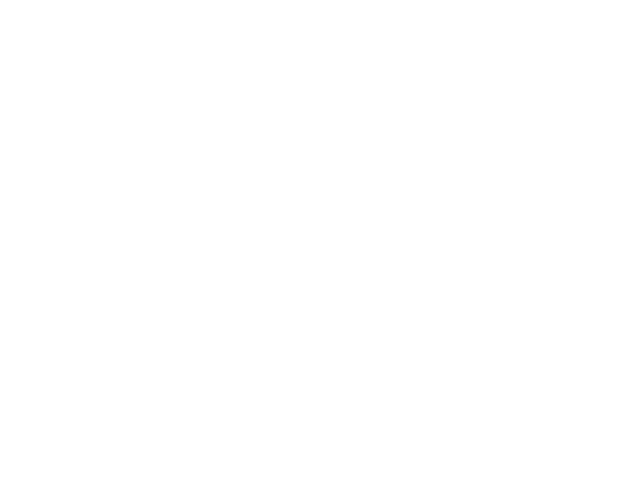

/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


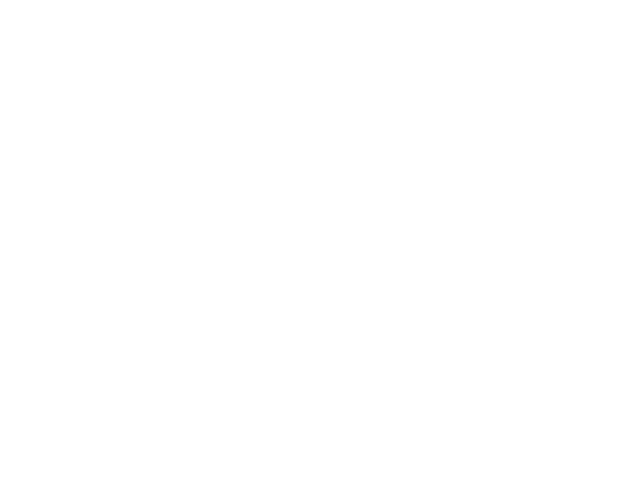

<IPython.core.display.Javascript object>


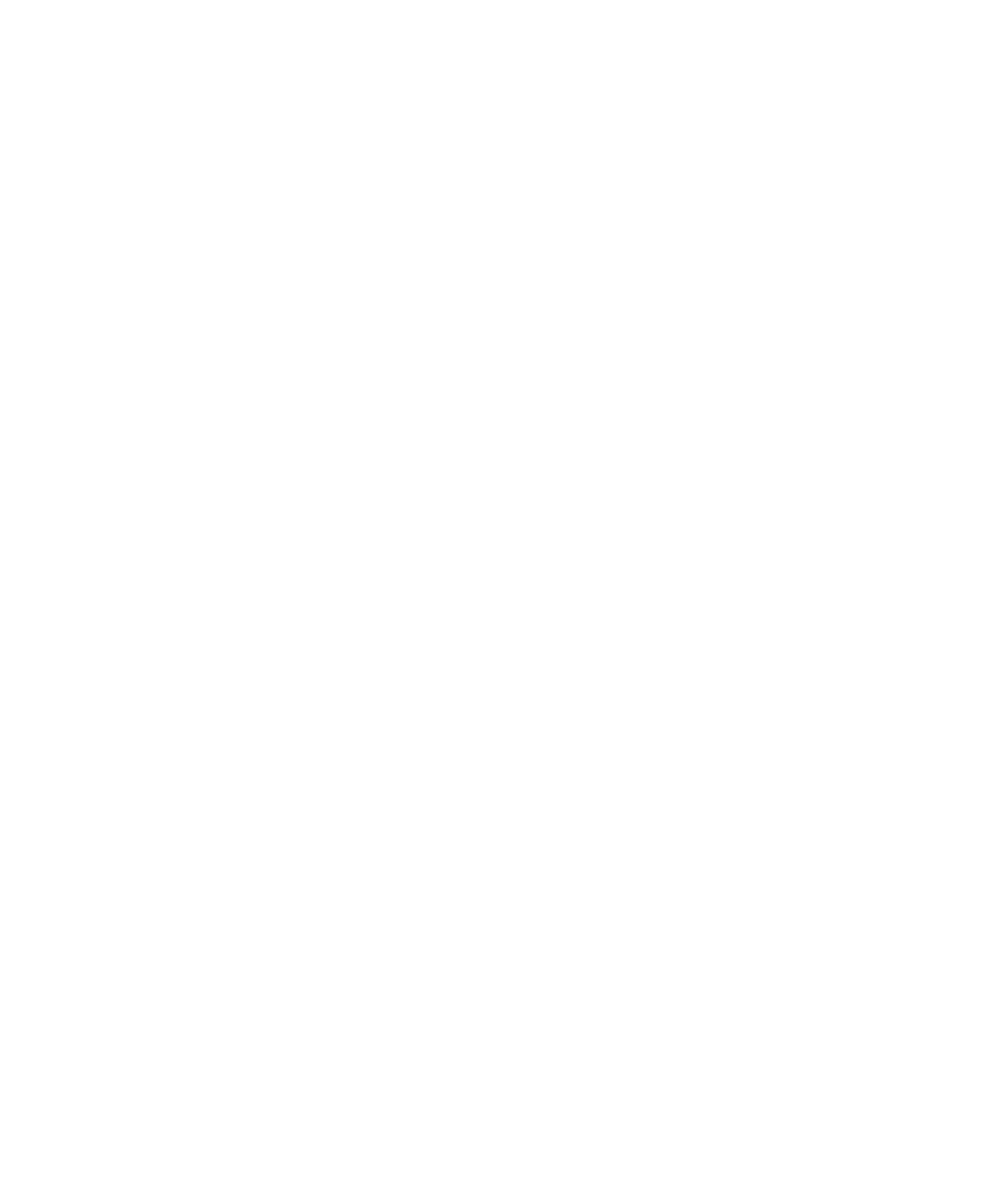

<IPython.core.display.Javascript object>


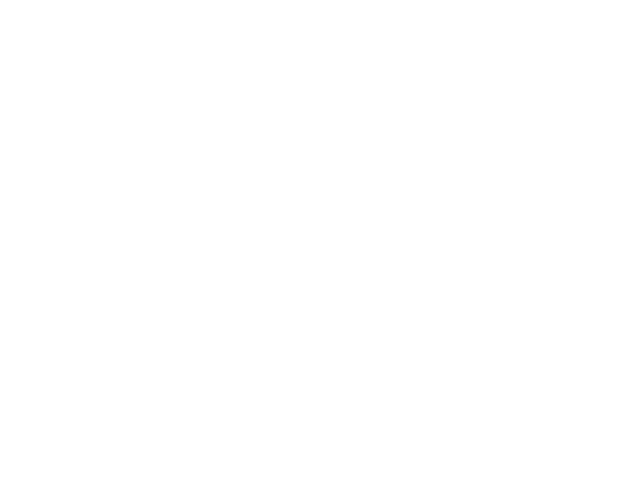

<IPython.core.display.Javascript object>


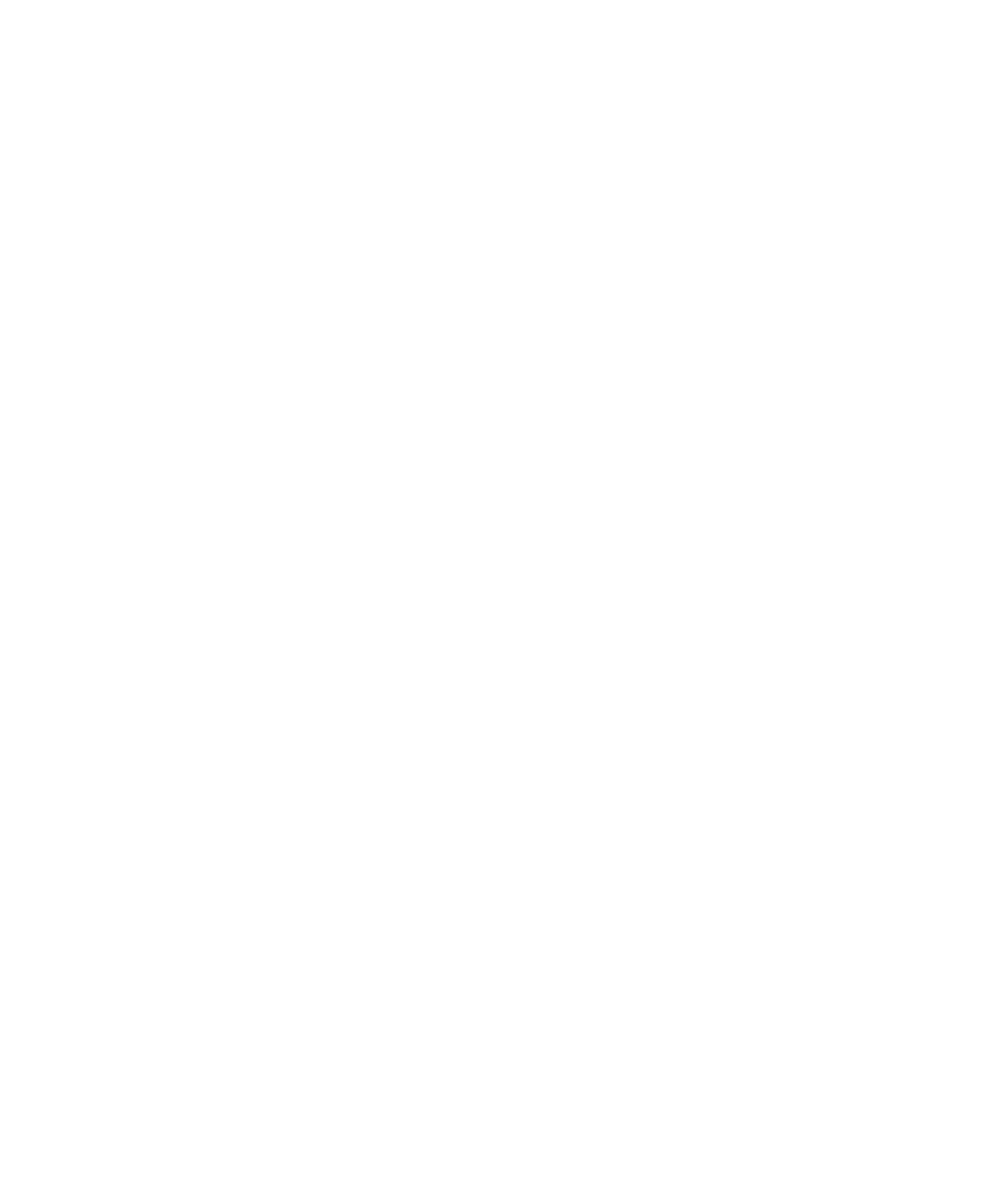

<IPython.core.display.Javascript object>


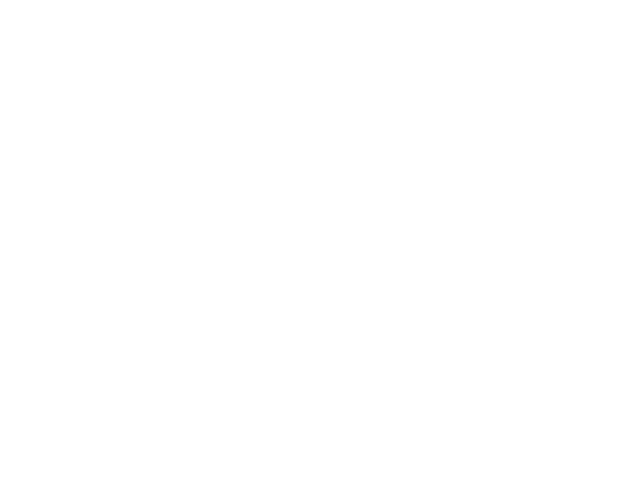

<IPython.core.display.Javascript object>


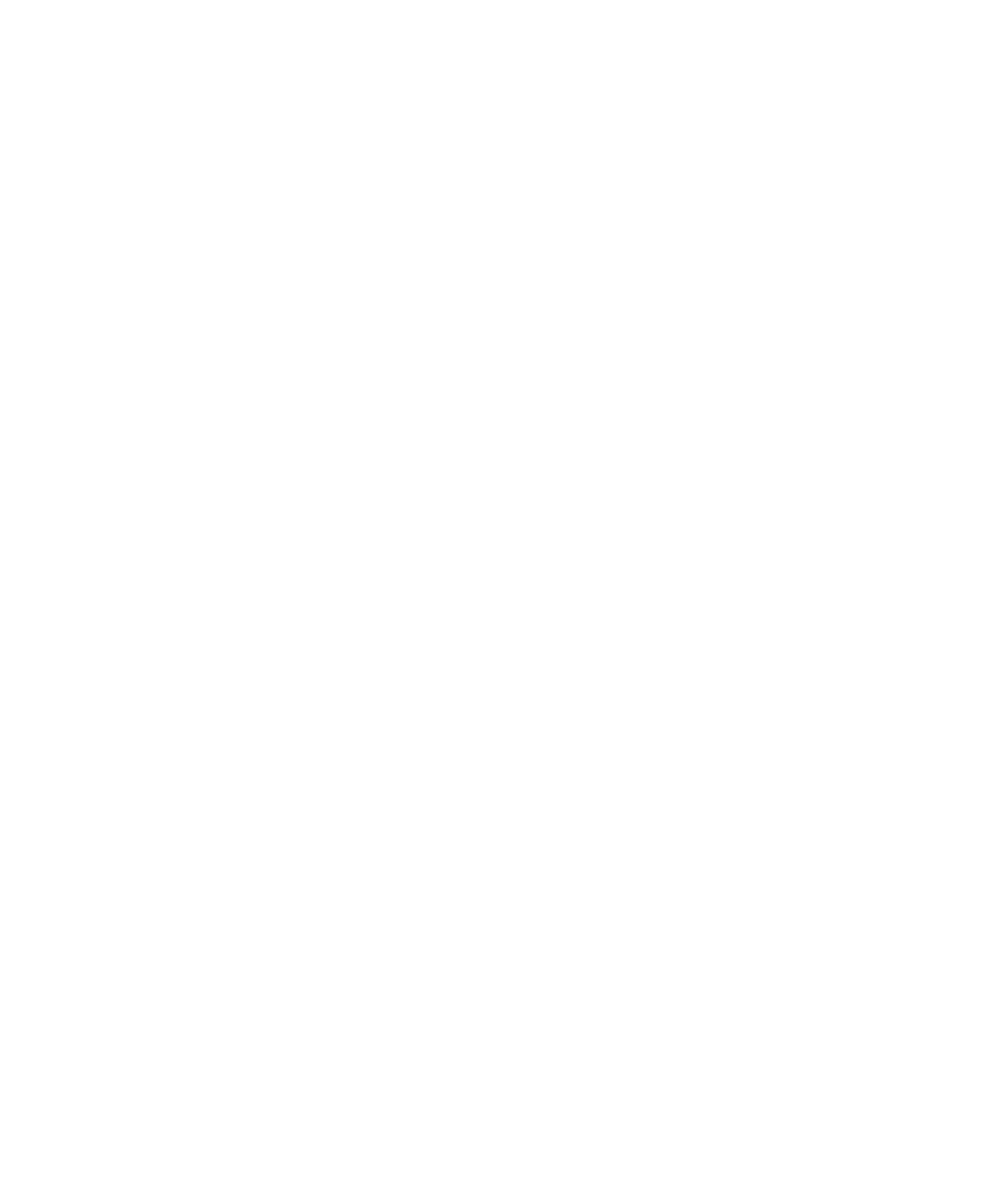

<IPython.core.display.Javascript object>


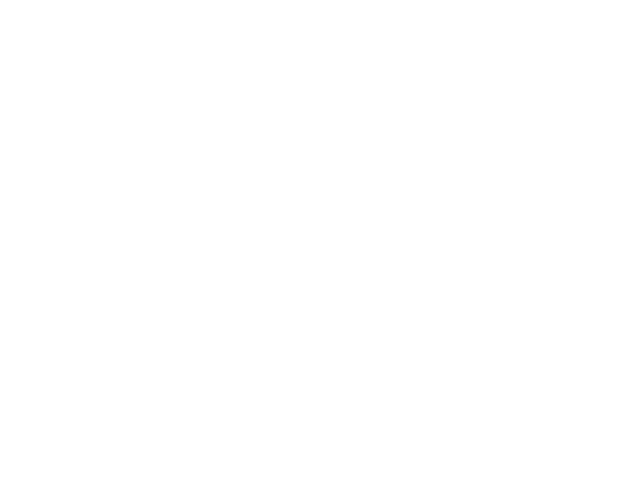

<IPython.core.display.Javascript object>


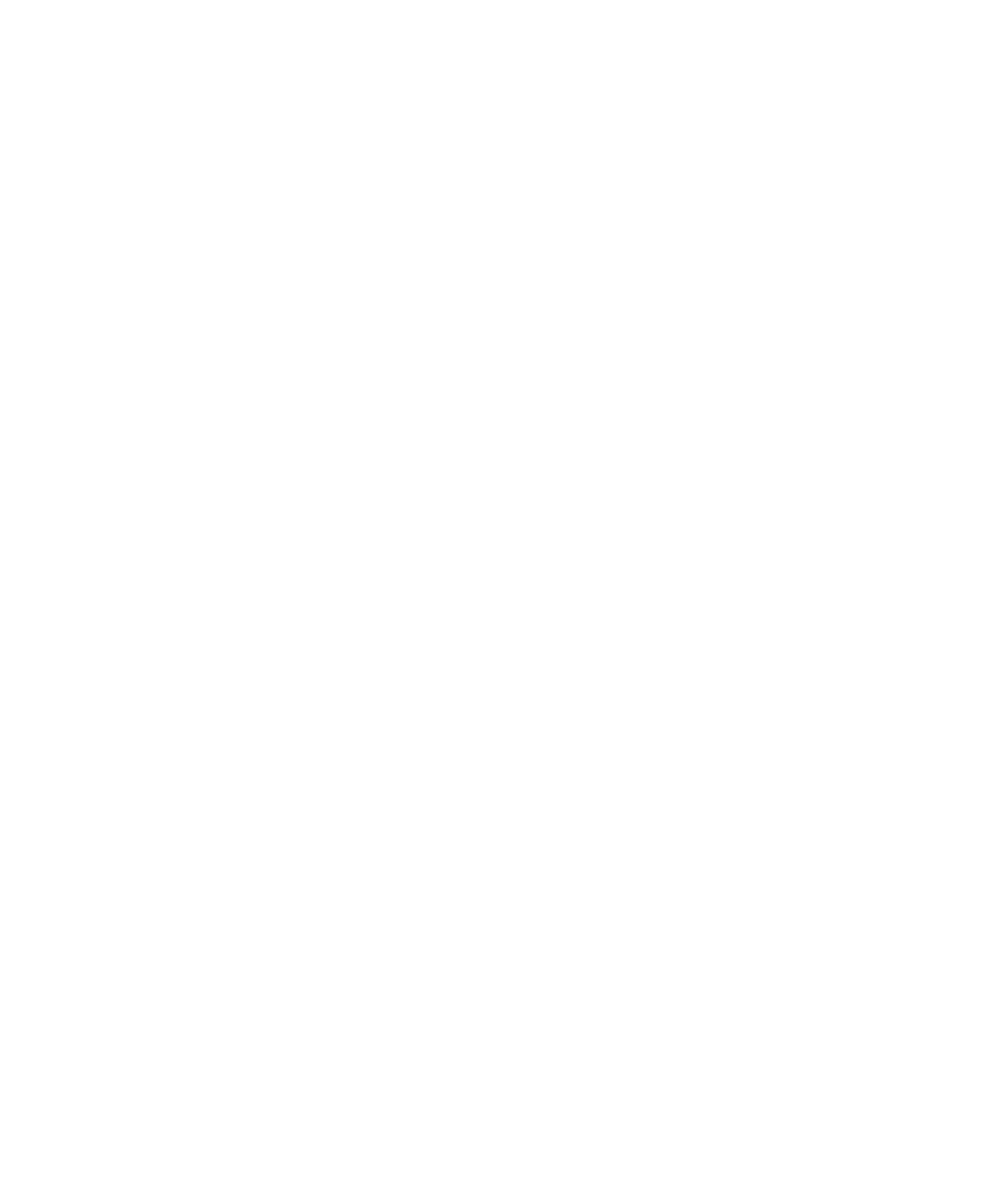

<IPython.core.display.Javascript object>


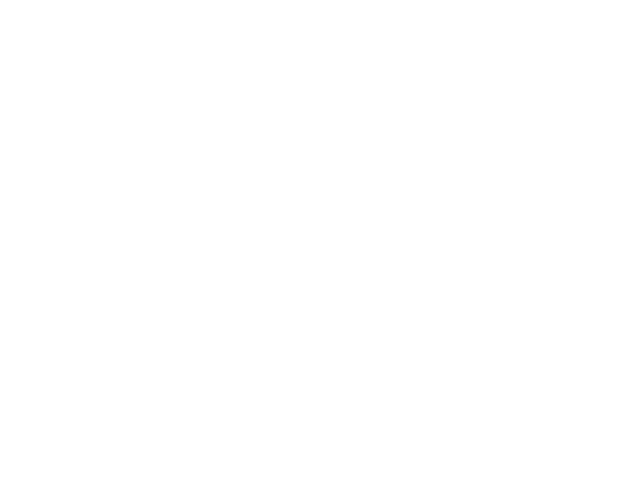

<IPython.core.display.Javascript object>


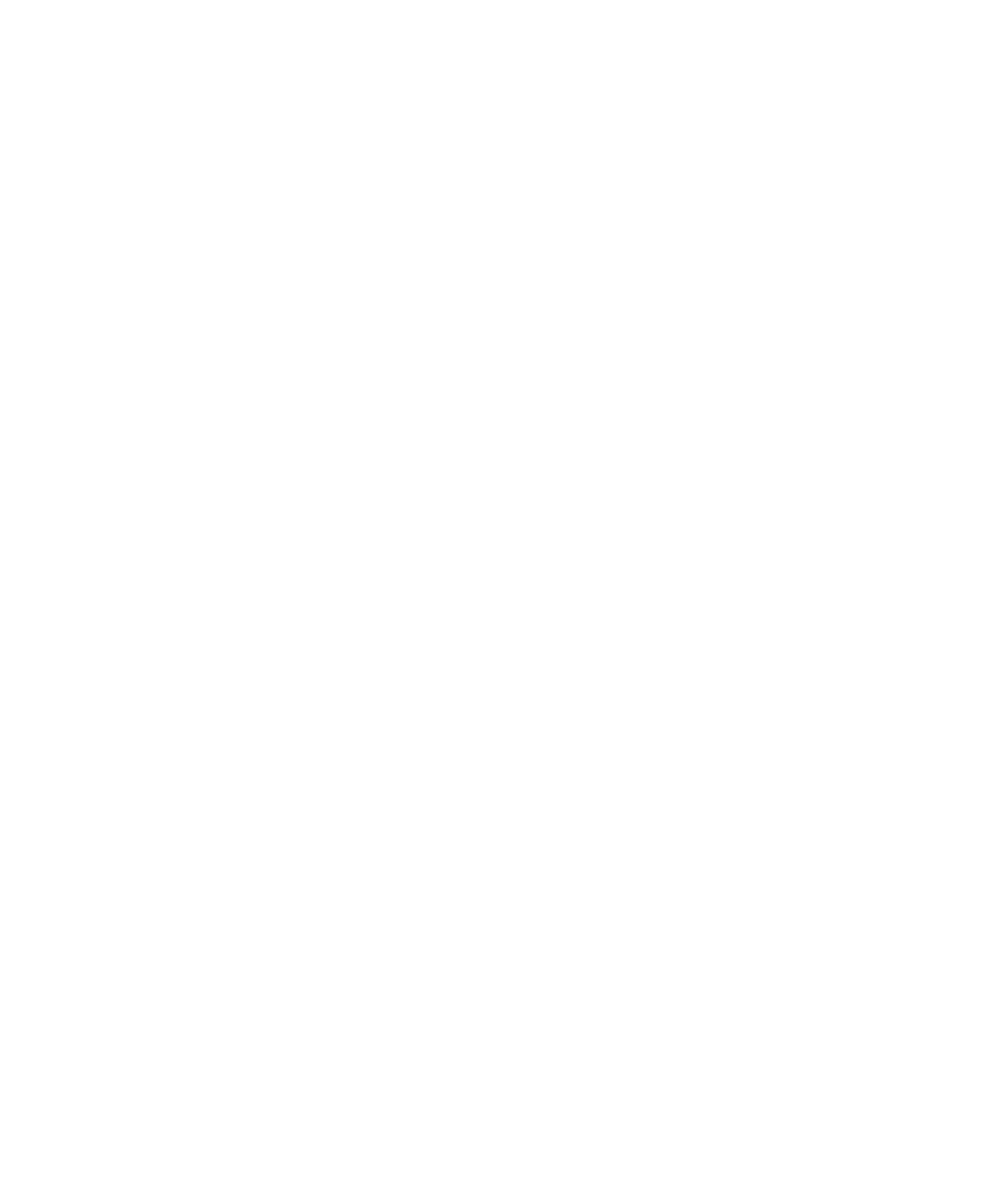

In [48]:
nClus=5
kmeans = KMeans(n_clusters=nClus, random_state=0).fit(wtANDmtDf_scaled[uncorr_features].values)
clusterLabels=kmeans.labels_
distances=kmeans.fit_transform(wtANDmtDf_scaled[uncorr_features].values)
wtANDmtDf_scaled['clusterLabels']=clusterLabels;
wtANDmtDf_scaled['dist2Mean']=np.min(distances,1);

DirsDict={}
DirsDict['root']=images_dir
DirsDict['resDir']=res_dir
# channels=['Mito','AGP','Brightfield','ER','DNA','Outline']
# channels=["DNA","RNA","Mito","ER","AGP"]
disLabels=['KO']
controlLabel='control'
d=X_Metadata_broad_sample;
# boxSize=160
clusteringHists(DirsDict,wtANDmtDf_scaled,controlLabel,d,nClus,uncorr_features,channels,boxSize)


In [36]:
boxSize

160

In [34]:
fig, axes = plt.subplots(figsize=(5,4))
perc99th=np.percentile(wtANDmtDf_scaled[selected_feature].values, 99);  
df_4_hist=wtANDmtDf_scaled[wtANDmtDf_scaled[selected_feature]<perc99th]
g=sns.displot(df_4_hist, x=selected_feature, hue="label",bins=40,legend="top")


In [28]:

# plt.legend(bbox_to_anchor=(0.5, 1), loc=9, borderaxespad=0.)

No handles with labels found to put in legend.


In [18]:
wtANDmtDf[1:100].shape

(99, 1096)

## Save outputs as a PDF file

In [ ]:
from fpdf import FPDF
pdf = FPDF()
# imagelist is the list with all image filenames
for image in imagelist:
    pdf.add_page()
    pdf.image(image,x,y,w,h)
    
pdf.output("yourfile.pdf", "F")

In [84]:
parent_dir=res_dir+'/'+controlLabel+'-'+d

from fpdf import FPDF
pdf = FPDF(format='Letter')
pdf.add_page()

# add dataframe
# x,y=100,100
x,y=100+15,10
w,h=20*4,20*4
pdf.image(parent_dir+"/target_hist.png",x,y,w,h)

# add target hist
x,y=5+5,15
# 620 × 350
w,h=int(620/6),int(350/6)
# w,h=20*4,20*3
pdf.image(parent_dir+"/df_info.png",x,y,w,h)

# add high_target_examplar
x,y=102,120
# w,h=20*4,20*8
w,h=int(1000/8),int(1200/8)
pdf.image(parent_dir+"/high_target_examplar.png",x,y,w,h)


# add low_target_examplar
x,y=-10,120
w,h=int(1000/8),int(1200/8)
# w,h=20*4,20*8
pdf.image(parent_dir+"/low_target_examplar.png",x,y,w,h)


pdf.output(res_dir+"/test.pdf", "F")

''

In [75]:
# pdf.output(res_dir+"/test.pdf", "F")
w,h=int(620/8),int(350/8)

In [117]:
# plt.figure()
# plt.imshow(skimage.io.imread(imPath))
# imageDir
f.savefig(resultsDir+'/'+contLabel+'-'+d1+'/cluster'+str(c)+'_examplar'+saveFormat)     

'/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/2016_04_01_a549_48hr_batch1_compressed/images/SQ00015165/'

<IPython.core.display.Javascript object>


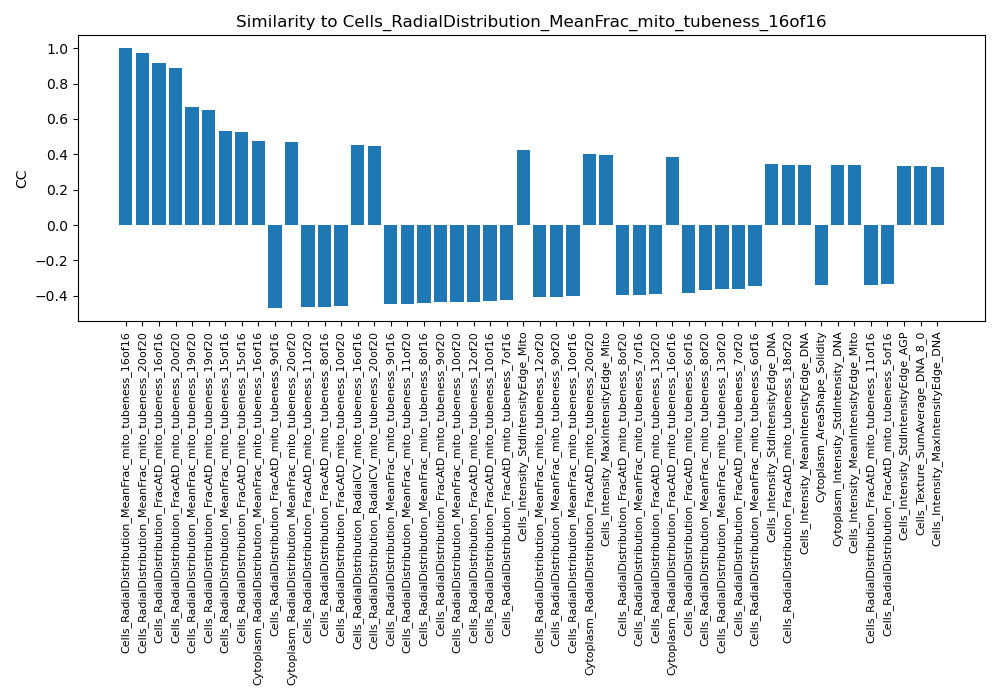

In [65]:
df_corr=pert_df_dmsos.copy()

otherFeatures=cp_features
targetFeature=selected_feature
columns = ['MI','CC'];
df_f_MI_CC= pd.DataFrame(index=otherFeatures,columns=columns)
refFeature=df_corr[targetFeature].values
for f in otherFeatures:
#     print(f)
    comparedFeature=df_corr[f].values;
    df_f_MI_CC.loc[f,'CC']=pearsonr(refFeature, comparedFeature)[0]

importances=df_f_MI_CC.loc[:,'CC'].values
indices = np.argsort(abs(importances))[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [otherFeatures[i] for i in indices]
plt.figure(figsize=(10,7))
# # Barplot: Add bars
# plt.bar(range(len(names)), importances[indices])
# # Add feature names as x-axis labels
# plt.xticks(range(len(names)), names, rotation=90, fontsize = 8)
top_n=50

plt.bar(range(top_n), importances[indices[0:top_n]])
# Add feature names as x-axis labels
plt.xticks(range(top_n), names, rotation=90, fontsize = 8)


# Create plot title
plt.title("Similarity to "+targetFeature)
plt.ylabel('CC')
# Show plot
plt.tight_layout()
plt.show()

In [43]:
# df_ss0.shape, pert_df_dmsos.shape
# dist2=euclidean_distances(mean_dmso.reshape(1, -1),mean_drug.reshape(1, -1))
# pearsonr(mean_dmso, mean_drug)
selected_feature

'Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16'

In [32]:
dist = np.linalg.norm(mean_dmso-mean_drug)
from sklearn.metrics.pairwise import euclidean_distances
dist2=euclidean_distances(mean_dmso,mean_drug)

NameError: name 'mean_dmso' is not defined

In [24]:
pert_df_dmsos.columns[pert_df_dmsos.columns.str.contains("Metadata")].tolist()

['Metadata_AbsPositionZ',
 'Metadata_AbsTime',
 'Metadata_BinningX',
 'Metadata_BinningY',
 'Metadata_ChannelID',
 'Metadata_ChannelName',
 'Metadata_Col',
 'Metadata_ExposureTime',
 'Metadata_FieldID',
 'Metadata_ImageResolutionX',
 'Metadata_ImageResolutionY',
 'Metadata_ImageSizeX',
 'Metadata_ImageSizeY',
 'Metadata_MainEmissionWavelength',
 'Metadata_MainExcitationWavelength',
 'Metadata_MaxIntensity',
 'Metadata_ObjectiveMagnification',
 'Metadata_ObjectiveNA',
 'Metadata_Plate',
 'Metadata_PositionX',
 'Metadata_PositionY',
 'Metadata_PositionZ',
 'Metadata_Row',
 'Metadata_Site',
 'Metadata_Well']

In [17]:
df_ss0["Count_Cells"].unique()

array([ 32.,  63.,  47.,  69.,  48.,  73., 100.,  60., 104.,  44.,  50.,
        51.,  35.,  62.,  65.,  56.,  57.,  58.,  67.,  71.,  79.,  36.,
        64.,  68.,  41.,  33.,  46.,  95.,  22.,  54.,  40.,  38.,  80.,
        76.])

In [22]:
df_ss0.groupby(["Metadata_Plate","Metadata_Well"]).size()

Metadata_Plate  Metadata_Well
SQ00015130      P22              596
SQ00015165      P22              455
SQ00015166      P22              546
SQ00015167      P22              485
SQ00015168      P22              499
dtype: int64

In [19]:
df_ss0["Count_Cells"].unique().sum()

1984.0

In [20]:
df_ss0["Count_Cells"].shape

(2581,)

In [49]:
df_f_MI_CC[df_f_MI_CC["CC"].abs()<0.2].sort_values(by="CC")

,CC
Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_14of20,-0.199226
Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_3of16,-0.199118
Nuclei_AreaShape_MeanRadius,-0.198449
Nuclei_Intensity_MassDisplacement_Mito,-0.196748
Cytoplasm_Texture_Correlation_DNA_8_0,-0.196523
...,...
Cells_Intensity_LowerQuartileIntensity_DNA,0.196626
Cells_RadialDistribution_MeanFrac_mito_tubeness_14of16,0.196957
Cells_Texture_Variance_DNA_8_90,0.198398
Cytoplasm_Texture_InfoMeas1_DNA_8_90,0.199271


In [45]:
df_f_MI_CC

,CC
Cells_AreaShape_Area,-0.194731
Cells_AreaShape_Center_X,-0.0154525
Cells_AreaShape_Center_Y,0.0620213
Cells_AreaShape_Compactness,0.231101
Cells_AreaShape_Eccentricity,0.179345
...,...
Nuclei_Texture_Variance_DNA_8_90,-0.0590907
Nuclei_Texture_Variance_Mito_8_0,0.0128604
Nuclei_Texture_Variance_Mito_8_135,0.00612752
Nuclei_Texture_Variance_Mito_8_45,0.0103195
